In [1]:
import importlib
import local_utils; importlib.reload(local_utils)
from local_utils import *

train_df = pd.read_csv(DATA_DIR + '/train_v2.csv')
test_df = pd.read_csv(DATA_DIR + '/sample_submission_v2.csv')

label_map, inv_label_map, Y = process_labels(train_df)
print("Shape of Y {}".format(Y.shape))

# train_inx, valid_inx = stratified_sampling(Y)
# print("Train {}; Valid {};".format(len(train_inx), len(valid_inx)))

Using TensorFlow backend.


Import time: 10.1967031955719
Import time: 0.00016760826110839844
Shape of Y (40479, 17)


In [2]:
train_df = pd.read_csv(DATA_DIR + '/train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
from sklearn.model_selection import StratifiedKFold
def stratified_kfold_sampling(Y, n_splits=5, num_classes=17, random_state=0):
    train_folds = [[] for _ in range(n_splits)]
    valid_folds = [[] for _ in range(n_splits)]
    inx = np.arange(len(Y))
    valid_size = 1.0 / n_splits

    for cl in range(0, num_classes):
        sss = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state+cl)
        
        for fold, (train_index, test_index) in enumerate(sss.split(inx, Y[:,cl])):
            b_train_inx, b_valid_inx = inx[train_index], inx[test_index]
            
            # to ensure there is no repetetion within each split and between the splits
            train_folds[fold] = train_folds[fold] + list(set(list(b_train_inx)) - set(train_folds[fold]) - set(valid_folds[fold]))
            valid_folds[fold] = valid_folds[fold] + list(set(list(b_valid_inx)) - set(train_folds[fold]) - set(valid_folds[fold]))
        
    return np.array(train_folds), np.array(valid_folds)

In [4]:
n_splits = 10
train_folds, valid_folds = stratified_kfold_sampling(Y, n_splits=n_splits)

In [5]:
for i in range(n_splits):
    print(len(train_folds[i]))
    print(len(valid_folds[i]))

36430
4049
36430
4049
36430
4049
36430
4049
36431
4048
36432
4047
36432
4047
36432
4047
36432
4047
36432
4047


In [6]:
buff_inx = []
for i in range(n_splits):
    buff_inx += valid_folds[i]

len(set(buff_inx))

40479

90
8


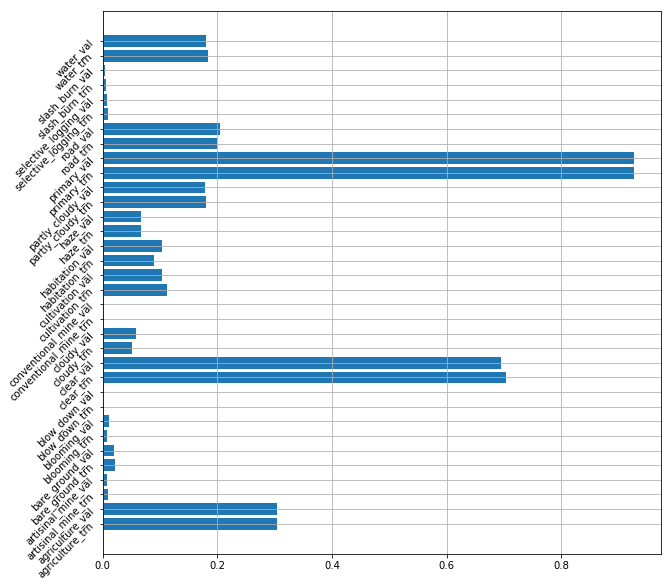

92
6


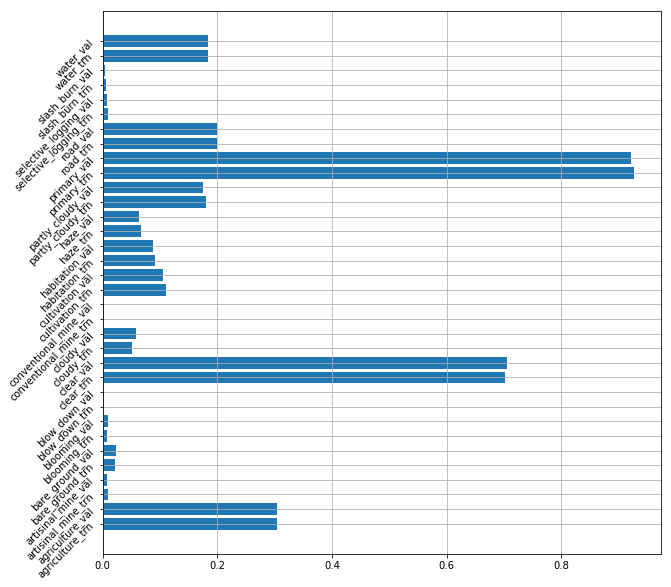

93
5


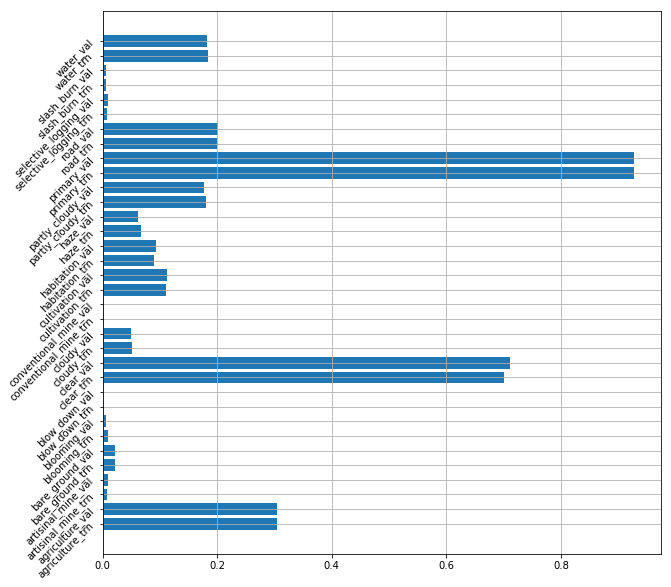

90
8


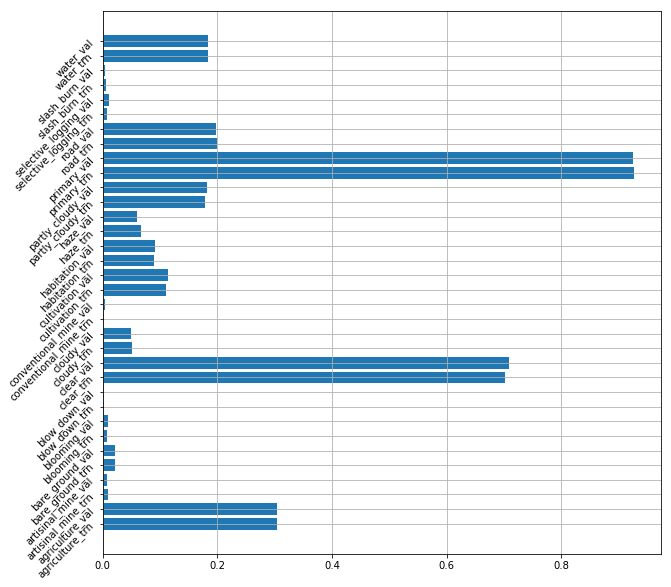

91
7


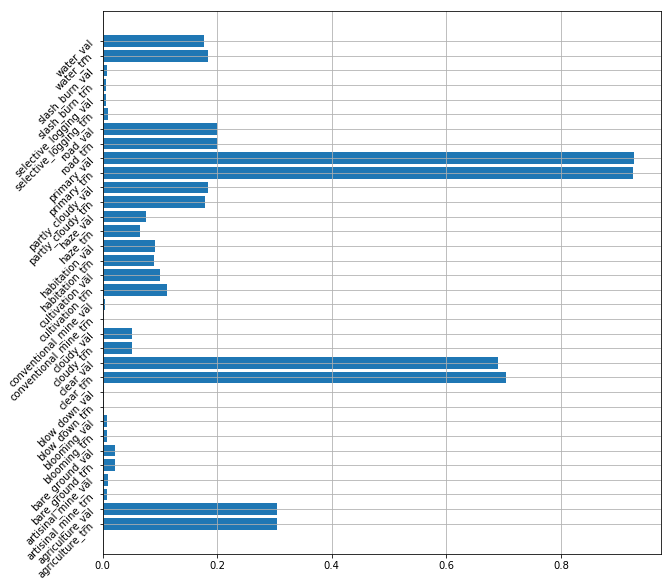

88
10


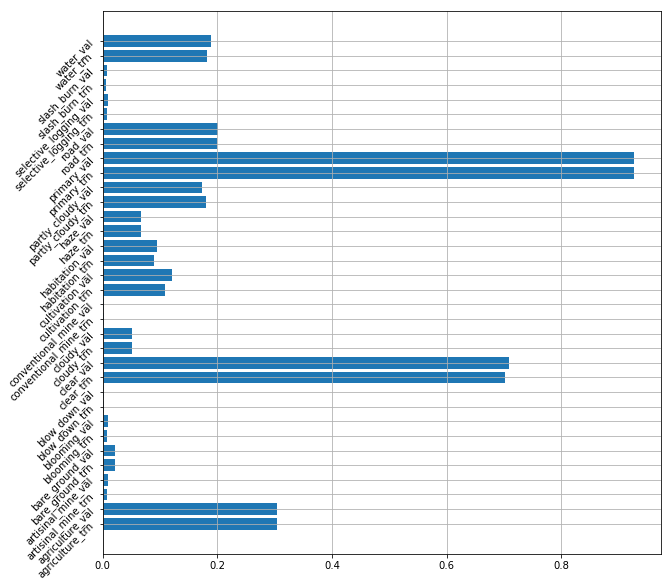

84
14


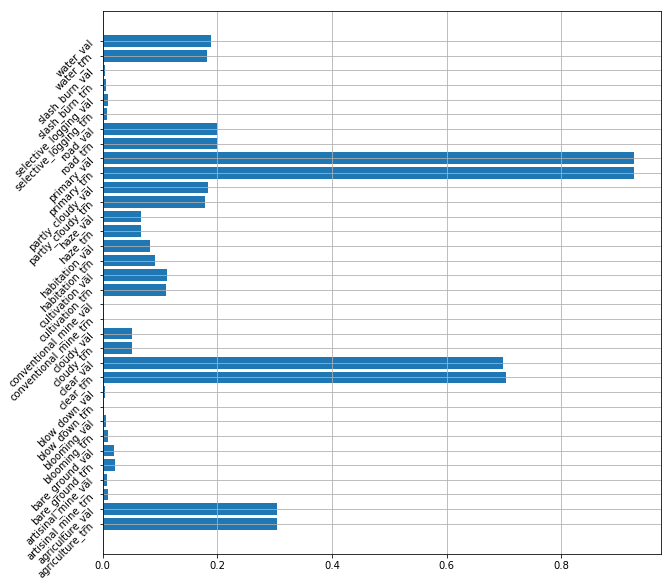

86
12


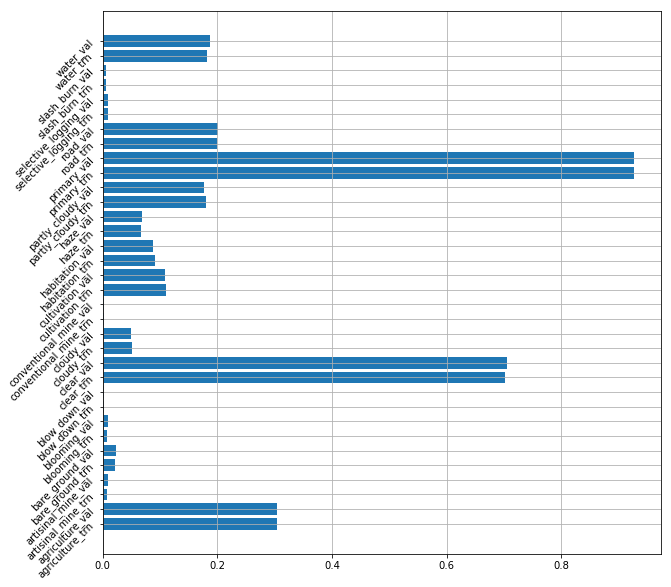

84
14


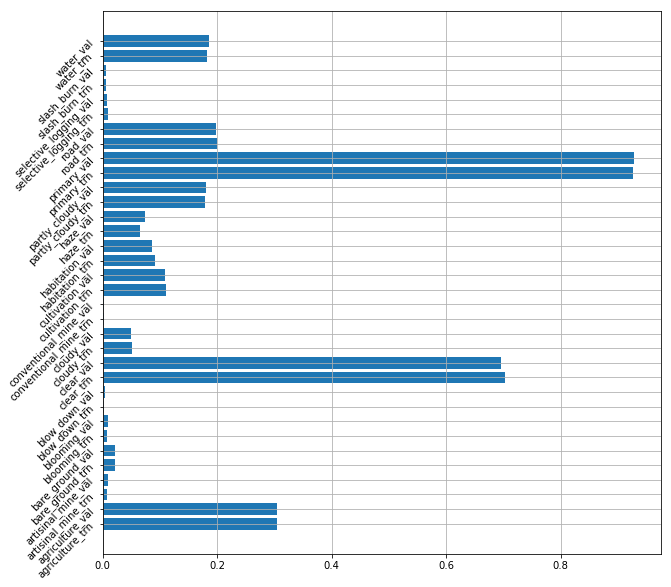

84
14


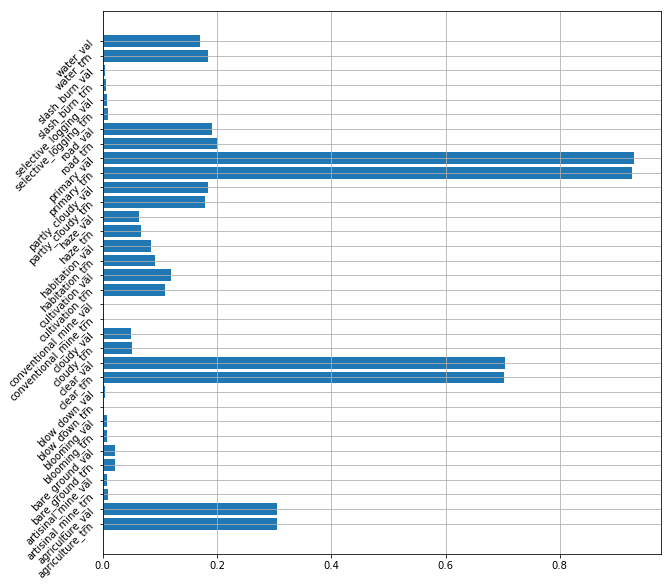

In [7]:
for train_inx, valid_inx in zip(train_folds, valid_folds):
    train_count = []
    valid_count = []
    dist = []
    #checking distribution for each class
    for i in range(17):
        train_count.append(np.unique(Y[train_inx,i],return_counts=True)[1][1])
        dist.append(train_count[-1]/len(train_inx))
        valid_count.append(np.unique(Y[valid_inx,i],return_counts=True)[1][1])
        dist.append(valid_count[-1]/len(valid_inx))
    dist_label = [x for pair in zip([x + '_trn' for x in (inv_label_map.values())],
                                    [x + '_val' for x in (inv_label_map.values())]) for x in pair]
    
    print(train_count[label_map['blow_down']])
    print(valid_count[label_map['blow_down']])
    
    plot = plt.figure(figsize=(10,10))
    plt.barh(np.arange(len(dist)),dist)
    plt.yticks(np.arange(len(dist)),dist_label,rotation = 45)
    plt.grid(True)
    plt.show()